<a href="https://colab.research.google.com/github/tylee33/transfer_learning_lecture/blob/main/Transfer_Learning_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **학습된 모델 재사용하기**

In [ ]:
! pip install tensorflow==1.4

     |████████████████████████████████| 41.2MB 115kB/s 
     |████████████████████████████████| 1.7MB 41.2MB/s 
     |████████████████████████████████| 890kB 37.5MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107220 sha256=f3bcaf4d83104ab8874d249f6d75e9ea38ecdfe0efe4a0529d8f790c16a59d71
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.2.1
    Uninstalling bleach-3.2.1:
      Successfully uninstalled bleach-3.2.1
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


# **1.환경 구성**

In [ ]:
import os
import numpy as np
import tensorflow as tf

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph() # tensorflow 1.4 호환
    tf.set_random_seed(seed)
    np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or 

# **기존 모델 학습의 한계**

규모가 매우 큰 DNN 모델을 학습 시킬 때 처음부터 새로 학습 시키는 것은 학습 속도가 느린 문제가 있다. 

이러한 경우 기존에 학습된 비슷한 DNN모델이 있을 때 이 모델의 하위층(lower layer)을 가져와 
재사용하는 것이 학습 속도를 빠르고
학습에 필요한 Training set도 훨씬 적다.

예를 들어, 아래의 그림처럼 CIFAR10 데이터셋을 분류(비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭의 10개 클래스)하는 모델 A가 이 있다고 하자. 
그런 다음, 분류된 CIFAR10 이미지에서 자동차의 종류를 분류하는 모델인 B를 학습시킨다고 할 때, 학습된 모델 A에서의 일부분(lower layer)을 재사용하여 
모델 B를 학습 시킬 수 있다. 이러한 방법을 Transfer Learning이라고 한다.

이러한 Transfer Learning을 텐서플로를 이용해서 어떻게 학습시킬 수 있는지에 대해 알아보도록 하자.

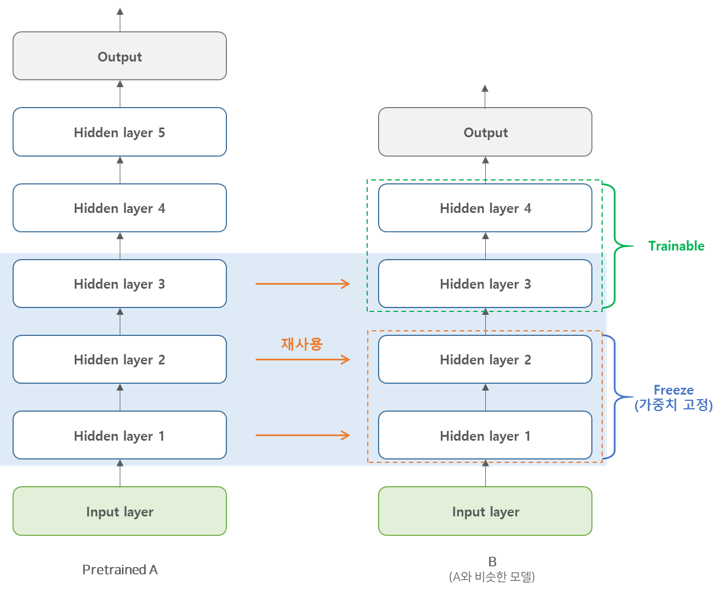

### **학습된 모델 저장하기**

아래의 예제 코드는, 5개의 hidden layer로 구성된 MNIST 데이터셋을 분류하는 모델이다.

tf.train.Saver를 이용해 학습된 모델을 'my_model.ckpt'에 저장하는 코드이다.

In [ ]:
import os
import numpy as np
import tensorflow as tf

# MNIST Load
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

# Train & TestSet reshape
train_x = train_x.astype(np.float32).reshape(-1, 28*28) / 255.
train_y = train_y.astype(np.int32)
test_x = test_x.astype(np.float32).reshape(-1, 28*28) / 255.
test_y = test_y.astype(np.int32)

# Split Validation set from Train set
valid_x, train_x = train_x[:5000], train_x[5000:]
valid_y, train_y = train_y[:5000], train_y[5000:]

In [ ]:
def shuffle_batch(inputs, labels, batch_size):
    rnd_idx = np.random.permutation(len(inputs))
    n_batches = len(inputs) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        batch_x, batch_y = inputs[batch_idx], labels[batch_idx]
        yield batch_x, batch_y

In [ ]:
reset_graph()

################
# layer params #
################
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

# input layer
inputs = tf.placeholder(tf.float32, shape=[None, n_inputs], name="inputs")
# output layer
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(inputs, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2')
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name='hidden3')
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name='hidden4')
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name='hidden5')
    logits = tf.layers.dense(hidden5, n_outputs, name='logits')
    
with tf.name_scope('loss'):
    cross_entropy = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    
################
# Hyper-params #
################
learning_rate = 0.01
n_epochs = 5
batch_size = 50

with tf.name_scope('train'):
    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, labels, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
# Saver 정의
MODEL_PATH = './model/'
saver = tf.train.Saver()

# 모델을 쉽게 재사용 할 수 있도록 
# 텐서플로 컬렉션(collection)에 저장
train_vars = {'inputs': inputs, 'labels': labels,
              'hidden1': hidden1, 'hidden2': hidden2,
              'hidden3': hidden3, 'hidden4': hidden4,
              'hidden5': hidden5, 'logits': logits}

for key, var in train_vars.items():
    tf.add_to_collection(key, var)

# Train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for epoch in range(n_epochs):
        for batch_x, batch_y in shuffle_batch(train_x, train_y, batch_size):
            sess.run(train_op, feed_dict={inputs: batch_x, 
                                          labels: batch_y})
            
        # validation
        accuracy_val = accuracy.eval(feed_dict={inputs: valid_x, labels: valid_y})
        print('epoch: {:02d}, valid. Acc: {:.4f}'.format(epoch, accuracy_val))
    
    # model save
    save_path = saver.save(sess, os.path.join(MODEL_PATH, 'my_model.ckpt'))

epoch: 00, valid. Acc: 0.8768
epoch: 01, valid. Acc: 0.9278
epoch: 02, valid. Acc: 0.9466
epoch: 03, valid. Acc: 0.9544
epoch: 04, valid. Acc: 0.9578


# **2.학습된 모델을 이용해 4번째 레이어만 수정하기**

이제 '1.1-학습된 모델 저장하기' 에서 저장한 'my_model.ckpt'을 이용해, 4번째 hidden layer의 노드 수를 20개로 수정한 뒤 새로운 모델을 학습시키는 코드이다. 아래의 코드는 위의 코드에서 tf.add_to_collection에 저장한 inputs, labels, hidden3를 불러온 뒤, new_hidden4, new_logits을 추가한 새로운 모델을 학습하여 my_new_model.ckpt에 저장하는 코드이다.

In [ ]:
reset_graph()

#################
# layers params #
#################
n_hidden4 = 20  # new hidden # 4번째 hidden layer의 노두 수를 20개로 수정
n_outputs = 10  # new output

MODEL_PATH = './model/'
saver = tf.train.import_meta_graph(os.path.join(MODEL_PATH, 'my_model.ckpt.meta'))

inputs = tf.get_default_graph().get_collection('inputs')[0]
labels = tf.get_default_graph().get_collection('labels')[0]

hidden3 = tf.get_default_graph().get_collection('hidden3')[0]

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name='new_hidden4')
new_logits = tf.layers.dense(new_hidden4, n_outputs, name='new_logits')

with tf.name_scope('new_loss'):
    cross_entropy = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=new_logits))
    
################
# Hyper-params #
################
learning_rate = 0.001
n_epochs = 5
batch_size = 50

with tf.name_scope('new_train'):
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
    
with tf.name_scope('new_eval'):
    correct = tf.nn.in_top_k(new_logits, labels, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# New Saver
new_saver = tf.train.Saver()
    
# Train the New Model
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, os.path.join(MODEL_PATH, 'my_model.ckpt'))
    
    for epoch in range(n_epochs):
        for batch_x, batch_y in shuffle_batch(train_x, train_y, batch_size):
            sess.run(train_op, feed_dict={inputs: batch_x, 
                                          labels: batch_y})
            
        # validation
        accuracy_val = accuracy.eval(feed_dict={inputs: valid_x, labels: valid_y})
        print('epoch: {:02d}, valid. Acc: {:.4f}'.format(epoch, accuracy_val))
    
    # save the new model
    save_path = new_saver.save(sess, os.path.join(MODEL_PATH, 'my_new_model.ckpt'))

INFO:tensorflow:Restoring parameters from ./model/my_model.ckpt
epoch: 00, valid. Acc: 0.9658
epoch: 01, valid. Acc: 0.9702
epoch: 02, valid. Acc: 0.9672
epoch: 03, valid. Acc: 0.9762
epoch: 04, valid. Acc: 0.9762


# **3.텐서플로를 이용한 Transfer Learning**

이번에는 텐서플로를 이용해 
* 'Transfer Learning이란'에서 살펴본 Transfer Learning을 구현해보도록 하자.
* '학습된 모델 저장하기'의 예제코드를 통해 저장한 'my_model.ckpt'에서 hidden1, hidden2 레이어는 Freezing(동결)한 뒤 재사용 하고, hidden3레이어는 Freezing하지 않고 재사용(즉, 학습시킨 다는 의미)한다. 그리고 마지막으로 hidden4, logits를 새로 만들어 transfer learning을 수행해보자.

## 3.1 재사용할 레이어 동결(freezing)하는 방법 (1)

우선, 학습시킬 레이어(hidden3, hidden4, logits)와 동결(학습시키지 않을)할 레이어(hidden1, hidden2)를 텐서플로의 tf.get_collection()을 이용하여 다음과 같이 설정해줘야 한다.

학습시킬 레이어(hidden3, hidden4, logits) : tf.get_collection()의 sope인자에 정규표현식으로 학습시킬 레이어를 아래의 코드처럼 'hidden[34]|logits'라고 지정하면 텐서의 name이 매칭되는 레이어를 찾는다. 그런 다음 optimizer.minimize()의 var_list인자에 넣어주면 된다.

# 학습시킬 레이어 설정 예시
* optimizer = tf.train.GradientDescentOptimizer(learning_rate)
* train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='hidden[34]|logits')  # 정규표현식
* train_op = optimizer.minimize(loss, var_list=train_vars)

재사용할 레이어(hidden1~3) : 마찬가지로, tf.get_collection()의 scope인자에 정규표현식으로 'hidden[123]'을 넣어준 뒤 tf.train.Saver()에 넣어준다.

# 재 사용할 레이어 불러오는 예시
* reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='hidden[123]') # 정규표현식
* restore_saver = tf.train.Saver(reuse_vars)
* with tf.Session() as sess: restore_saver.restore(sess, './model/my_model.ckpt')
# 새 섹션
이제, 위에서 살펴본 내용을 토대로 재사용할 하위층(low layer)을 동결시킨 후 새로운 레이어를 추가한 새로운 모델을 학습시켜 보자.

In [ ]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300  # Reusing
n_hidden2 = 50  # Reusing
n_hidden3 = 50  # Reusing
n_hidden4 = 20  # New
n_outputs = 10  # New

inputs = tf.placeholder(tf.float32, shape=[None, n_inputs], name='inputs')
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(inputs, n_hidden1, 
                              activation=tf.nn.relu, name='hidden1')  # Reusing
    hidden2 = tf.layers.dense(hidden1, n_hidden2, 
                              activation=tf.nn.relu, name='hidden2')  # Reusing   
    hidden3 = tf.layers.dense(hidden2, n_hidden3, 
                              activation=tf.nn.relu, name='hidden3')  # Reusing   
    hidden4 = tf.layers.dense(hidden3, n_hidden4, 
                              activation=tf.nn.relu, name='hidden4')  # New  
    logits = tf.layers.dense(hidden4, n_outputs, name='logits')  # new
    
with tf.name_scope('loss'):
    cross_entropy = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    
################
# Hyper-params #
################
learning_rate = 0.01
n_epochs = 5
batch_size = 50

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope='hidden[34]|logits') # 학습시킬 Layer 불러오기
    train_op = optimizer.minimize(cross_entropy, var_list=train_vars)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, labels, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
# New Saver 정의
MODEL_PATH = './model/'
new_saver = tf.train.Saver()

# Reusing layer load
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope='hidden[123]') # 재사용 할 Layer 불러오기
restore_saver = tf.train.Saver(reuse_vars)

# Train the New Model
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    restore_saver.restore(sess, os.path.join(MODEL_PATH, 'my_model.ckpt'))
    
    for epoch in range(n_epochs):
        for batch_x, batch_y in shuffle_batch(train_x, train_y, batch_size):
            sess.run(train_op, feed_dict={inputs: batch_x, 
                                          labels: batch_y})
            
        # validation
        accuracy_val = accuracy.eval(feed_dict={inputs: valid_x, labels: valid_y})
        print('epoch: {:02d}, valid. Acc: {:.4f}'.format(epoch, accuracy_val))
    
    # save the new model
    save_path = new_saver.save(sess, os.path.join(MODEL_PATH, 'my_transfer_model.ckpt'))

INFO:tensorflow:Restoring parameters from ./model/my_model.ckpt
epoch: 00, valid. Acc: 0.9480
epoch: 01, valid. Acc: 0.9520
epoch: 02, valid. Acc: 0.9580
epoch: 03, valid. Acc: 0.9576
epoch: 04, valid. Acc: 0.9584


## 3.2 재사용할 레이어 동결(freezing)하는 방법
위에서 처럼 optimizer.minimize()의 var_list의 인자로 학습 시킬 레이어를 지정해주는 방법 말고 tf.stop_gradient()를 사용해 Transfer Learning을 수행할 수 있다. 

아래의 예시 코드처럼 동결(freezing)시킬 마지막 레이어(여기서는 hidden2) 바로뒤에 tf.stop_gradient()를 넣어주면 된다.

# tf.stop_gradient()를 사용한 Transfer Learning
* hidden2 = tf.layers.dense(hidden1, ...)
* hidden2_stop = tf.stop_gradient(hidden2)
* hidden3 = tf.layers.dense(hidden2_stop, ...)
# ...
아래의 코드는 위의 예제코드를 tf.stop_gradient()를 사용해 작성한 코드이다.

In [ ]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300  # Reusing
n_hidden2 = 50  # Reusing
n_hidden3 = 50  # Reusing
n_hidden4 = 20  # New
n_outputs = 10  # New

inputs = tf.placeholder(tf.float32, shape=[None, n_inputs], name='inputs')
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(inputs, n_hidden1, 
                              activation=tf.nn.relu, name='hidden1')  # Reusing
    hidden2 = tf.layers.dense(hidden1, n_hidden2, 
                              activation=tf.nn.relu, name='hidden2')  # Reusing
    hidden2_stop = tf.stop_gradient(hidden2)  # freezing # 재사용할 Layer 동결하기
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, 
                              activation=tf.nn.relu, name='hidden3')  # Reusing   
    hidden4 = tf.layers.dense(hidden3, n_hidden4, 
                              activation=tf.nn.relu, name='hidden4')  # New  
    logits = tf.layers.dense(hidden4, n_outputs, name='logits')  # new
    
with tf.name_scope('loss'):
    cross_entropy = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    
################
# Hyper-params #
################
learning_rate = 0.01
n_epochs = 5
batch_size = 50

with tf.name_scope('train'):
    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, labels, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
# New Saver 정의
MODEL_PATH = './model/'
new_saver = tf.train.Saver()

# Reusing layer load
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope='hidden[123]')
restore_saver = tf.train.Saver(reuse_vars)

# Train the New Model
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    restore_saver.restore(sess, os.path.join(MODEL_PATH, 'my_model.ckpt'))
    
    for epoch in range(n_epochs):
        for batch_x, batch_y in shuffle_batch(train_x, train_y, batch_size):
            sess.run(train_op, feed_dict={inputs: batch_x, 
                                          labels: batch_y})
            
        # validation
        accuracy_val = accuracy.eval(feed_dict={inputs: valid_x, labels: valid_y})
        print('epoch: {:02d}, valid. Acc: {:.4f}'.format(epoch, accuracy_val))
    
    # save the new model
    save_path = new_saver.save(sess, os.path.join(MODEL_PATH, 'my_transfer_model2.ckpt'))

INFO:tensorflow:Restoring parameters from ./model/my_model.ckpt
epoch: 00, valid. Acc: 0.9494
epoch: 01, valid. Acc: 0.9540
epoch: 02, valid. Acc: 0.9550
epoch: 03, valid. Acc: 0.9562
epoch: 04, valid. Acc: 0.9574


## 3.3 동결시킨 층 캐싱하기
위에서 hidden1, hidden2레이어를 재사용함과 동시에 동결(freezing) 시켰는데, 이러한 동결된 레이어는 변하지 않으므로 가장 마지막 동결된 레이어(hidden2)에서 나온 출력을 다음과 캐싱(caching) 할 수 있다.

전체 Training Set으로 마지막 동결된 레이어 hidden2의 출력을 실행한다. →(충분한 메모리가 있다는 가정하에)
학습하는 동안 Training Set에 대한 미니배치가 아닌 1에서 출력한 hidden2레이어의 출력에 대해 미니배치를 만든 다음 레이어에 넣어준다.

In [ ]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300  # Reusing
n_hidden2 = 50  # Reusing
n_hidden3 = 50  # Reusing
n_hidden4 = 20  # New
n_outputs = 10  # New

inputs = tf.placeholder(tf.float32, shape=[None, n_inputs], name='inputs')
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(inputs, n_hidden1, 
                              activation=tf.nn.relu, name='hidden1')  # Reusing
    hidden2 = tf.layers.dense(hidden1, n_hidden2, 
                              activation=tf.nn.relu, name='hidden2')  # Reusing
    hidden2_stop = tf.stop_gradient(hidden2)  # freezing
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, 
                              activation=tf.nn.relu, name='hidden3')  # Reusing   
    hidden4 = tf.layers.dense(hidden3, n_hidden4, 
                              activation=tf.nn.relu, name='hidden4')  # New  
    logits = tf.layers.dense(hidden4, n_outputs, name='logits')  # new
    
with tf.name_scope('loss'):
    cross_entropy = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    
################
# Hyper-params #
################
learning_rate = 0.01
n_epochs = 5
batch_size = 50

with tf.name_scope('train'):
    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, labels, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
# New Saver 정의
MODEL_PATH = './model/'
new_saver = tf.train.Saver()

# Reusing layer load
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope='hidden[123]')
restore_saver = tf.train.Saver(reuse_vars)

# Train
n_batches = len(train_x) // batch_size

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    restore_saver.restore(sess, os.path.join(MODEL_PATH, 'my_model.ckpt'))
    
    # Caching
    h2_cache = sess.run(hidden2, feed_dict={inputs: train_x})
    h2_cache_valid = sess.run(hidden2, feed_dict={inputs: valid_x})
    
    for epoch in range(n_epochs):
        # mini-batch for hidden2
        shuffle_idx = np.random.permutation(len(train_x))
        hidden2_batches = np.array_split(h2_cache[shuffle_idx], n_batches)
        label_batches = np.array_split(train_y[shuffle_idx], n_batches)
        for hidden2_batch, label_batch in zip(hidden2_batches, label_batches):
            sess.run(train_op, feed_dict={hidden2: hidden2_batch, 
                                          labels: label_batch})
            
        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid,
                                                labels: valid_y})
        print('epoch: {:02d}, valid. Acc: {:.4f}'.format(epoch, accuracy_val))
    
    # save the new model
    save_path = new_saver.save(sess, os.path.join(MODEL_PATH, 'my_caching_model.ckpt'))

INFO:tensorflow:Restoring parameters from ./model/my_model.ckpt
epoch: 00, valid. Acc: 0.9494
epoch: 01, valid. Acc: 0.9540
epoch: 02, valid. Acc: 0.9550
epoch: 03, valid. Acc: 0.9562
epoch: 04, valid. Acc: 0.9574
